In [2]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix

In [3]:
import seaborn as sns
sns.set_style('darkgrid')
import requests
import sys
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ast
import random
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation
import nltk
from nltk.text import Text
from datetime import datetime, timedelta
import string


In [3]:
file = ("../Pat/reddit_wallstreetbets.db")
# create a connection to the WSB database file
conn = sqlite3.connect(file)
# create our cursor (this allows us to execute SQL code chunks written as python strings)
c = conn.cursor()

In [4]:
#Print out database numbers before ending iteration
c.execute("SELECT * FROM new_posts")
new_posts_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])
print( 'new_posts now has '+str(len(new_posts_df))+' entries.' )
c.execute("SELECT * FROM post_stats")
post_stats_df = pd.DataFrame(c.fetchall(), columns = [x[0] for x in c.description])
print( 'post_stats now has '+str(len(post_stats_df))+' entries.' )

new_posts now has 6144 entries.
post_stats now has 129693 entries.


In [5]:
incomplete_entries = []
upvotes_24hrs = []
top_hot_loc = []
for i in range(len(new_posts_df)):
    c.execute("SELECT upvotes FROM post_stats where hour=24 and post_id="+str(i))
    fetch_val = c.fetchall()
    if len( fetch_val ) < 1:
        incomplete_entries.append(i)
    else:
        upvotes_24hrs.append( fetch_val[0][0] )
    c.execute("SELECT hot_val FROM post_stats where post_id="+str(i))
    top_hot_loc.append( min(c.fetchall())[0] )


In [6]:
time_vals = []
days = []
for i in range(len(new_posts_df)):
    time_str = new_posts_df["submit_time"][i].split('T')[1]
    time_val = float(time_str.split(':')[0])+float(time_str.split(':')[1])/60.+float(time_str.split(':')[2])/360.
    time_vals.append(time_val)
    days.append( pd.Timestamp( new_posts_df["submit_time"][i].split('T')[0].replace('"','') ).day_name() )

new_posts_df['submit_hour'] = time_vals
new_posts_df['submit_day'] = days
new_posts_df['best_hot_val'] = top_hot_loc

WSB_df = new_posts_df.drop(incomplete_entries)
WSB_df['upvotes_tot'] = upvotes_24hrs


In [7]:
WSB_df.head()

,post_id,active_track,title,comment_url,link_url,flair,submit_time,rising_val,hot_val,username,post_karma,comment_karma,redditor_for,upvotes,upvote_percent,num_comments,submit_hour,submit_day,best_hot_val,upvotes_tot
2,2,No,"China Evergrande Ends Talks on Hopson Deal, As...",https://old.reddit.com/r/wallstreetbets/commen...,https://www.bloomberg.com/news/articles/2021-1...,News,"""2021-10-20T15:25:08",9,70,AppyWappy,2954,4259,1618.662336,2,75,9,15.438889,Wednesday,60,8
3,3,No,Impact of Federal Legalization on TLRY,https://old.reddit.com/r/wallstreetbets/commen...,https://old.reddit.com/r/wallstreetbets/commen...,DD,"""2021-10-20T15:24:28",4,91,MichKOG,12425,11004,1861.732471,1,53,18,15.477778,Wednesday,57,20
4,4,No,Novavax $NVAX is being investigated after big ...,https://old.reddit.com/r/wallstreetbets/commen...,https://www.globenewswire.com/news-release/202...,News,"""2021-10-20T15:09:17",5,49,johnboycutter,15608,4904,2034.134827,5,78,10,15.197222,Wednesday,46,20
5,5,No,I suggested this few weeks ago and I was ridic...,https://old.reddit.com/r/wallstreetbets/commen...,https://i.redd.it/4oj1aea3emu71.jpg,Gain,"""2021-10-20T15:01:54",2,24,MgKx,3234,1689,1497.069590,20,81,12,15.166667,Wednesday,24,76
6,6,No,WISHtards today...,https://old.reddit.com/r/wallstreetbets/commen...,https://i.redd.it/6mv5z7cctmu71.jpg,Meme,"""2021-10-20T16:27:23",99,22,Janto_2021,25893,43034,336.027425,20,92,3,16.513889,Wednesday,2,32171


In [8]:
title = WSB_df.title

In [9]:
title

2       China Evergrande Ends Talks on Hopson Deal, As...
3                  Impact of Federal Legalization on TLRY
4       Novavax $NVAX is being investigated after big ...
5       I suggested this few weeks ago and I was ridic...
6                                      WISHtards today...
                              ...                        
6046    Apples vision of the metaverse does not includ...
6047     It’s that time again - Brace yourselves #omicron
6050    Omicron Facts (clarifying false information), ...
6052                                     how retard am I?
6053            From Friday lets see what next week goes.
Name: title, Length: 5008, dtype: object

In [10]:
title.index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   12,
            ...
            6040, 6041, 6042, 6043, 6045, 6046, 6047, 6050, 6052, 6053],
           dtype='int64', length=5008)

In [11]:
symbolset = string.punctuation

In [12]:
n = len(title)
WSB_df["propernouns"] = np.zeros(n)
WSB_df["numbers"] = np.zeros(n)
WSB_df["hashtags"] = np.zeros(n)
WSB_df["symbols"] = np.zeros(n)
for i in title.index:
    text = title[i]
    words = nltk.word_tokenize(text)
    taggedtoken = nltk.pos_tag(words)
    NPcount = 0
    NUMcount = 0
    SYMcount = 0
    HASHcount = 0
    for word in taggedtoken:
        if word[1] == "NNP" or word[1] == "NNPS":
            NPcount += 1
        if word[1] == "JJ" or word[1] == "CD":
            NUMcount += 1
        if word[0] == "#":
            HASHcount += 1
        if word[0] in symbolset :
            SYMcount += 1
    WSB_df["propernouns"][i] = NPcount
    WSB_df["numbers"][i] = NUMcount
    WSB_df["hashtags"][i] = HASHcount
    WSB_df["symbols"][i] = SYMcount
    

<ipython-input-12-0d07b0f0272b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WSB_df["propernouns"][i] = NPcount
<ipython-input-12-0d07b0f0272b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WSB_df["numbers"][i] = NUMcount
<ipython-input-12-0d07b0f0272b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WSB_df["hashtags"][i] = HASHcount
<ipython-input-12-0d07b0f0272b>:26: SettingWithCopyWarning: 
A value is trying to be set on 

In [13]:
WSB_df.head()

,post_id,active_track,title,comment_url,link_url,flair,submit_time,rising_val,hot_val,username,...,upvote_percent,num_comments,submit_hour,submit_day,best_hot_val,upvotes_tot,propernouns,numbers,hashtags,symbols
2,2,No,"China Evergrande Ends Talks on Hopson Deal, As...",https://old.reddit.com/r/wallstreetbets/commen...,https://www.bloomberg.com/news/articles/2021-1...,News,"""2021-10-20T15:25:08",9,70,AppyWappy,...,75,9,15.438889,Wednesday,60,8,7.0,0.0,0.0,1.0
3,3,No,Impact of Federal Legalization on TLRY,https://old.reddit.com/r/wallstreetbets/commen...,https://old.reddit.com/r/wallstreetbets/commen...,DD,"""2021-10-20T15:24:28",4,91,MichKOG,...,53,18,15.477778,Wednesday,57,20,3.0,0.0,0.0,0.0
4,4,No,Novavax $NVAX is being investigated after big ...,https://old.reddit.com/r/wallstreetbets/commen...,https://www.globenewswire.com/news-release/202...,News,"""2021-10-20T15:09:17",5,49,johnboycutter,...,78,10,15.197222,Wednesday,46,20,2.0,1.0,0.0,1.0
5,5,No,I suggested this few weeks ago and I was ridic...,https://old.reddit.com/r/wallstreetbets/commen...,https://i.redd.it/4oj1aea3emu71.jpg,Gain,"""2021-10-20T15:01:54",2,24,MgKx,...,81,12,15.166667,Wednesday,24,76,5.0,1.0,0.0,5.0
6,6,No,WISHtards today...,https://old.reddit.com/r/wallstreetbets/commen...,https://i.redd.it/6mv5z7cctmu71.jpg,Meme,"""2021-10-20T16:27:23",99,22,Janto_2021,...,92,3,16.513889,Wednesday,2,32171,0.0,0.0,0.0,0.0


In [20]:
Y = WSB_df["upvotes_tot"]
X = WSB_df["propernouns"]

In [25]:
Y

2           8
3          20
4          20
5          76
6       32171
        ...  
6046       25
6047       53
6050      585
6052      134
6053       53
Name: upvotes_tot, Length: 5008, dtype: int64

In [28]:
from sklearn.linear_model import LinearRegression

In [32]:
reg = LinearRegression(copy_X = True)
reg.fit(X.values.reshape(-1,1),Y.values)

LinearRegression()

In [1]:
plt.figure(figsize=(10,8))

plt.scatter(X,Y.values, alpha = 0.5)

x_fit = np.linspace(X.values.min()-.5,
                X.values.max()+.5)

y_fit = reg.predict(x_fit.reshape(-1,1))

plt.yscale('log')
plt.plot(x_fit,y_fit, 'r--',linewidth = 1.5)


plt.show()

NameError: name 'plt' is not defined

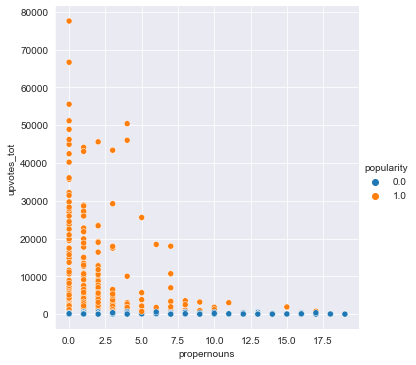

In [58]:
sns.relplot(
    data = WSB_df,
    x = "propernouns", y = "upvotes_tot", hue="popularity")

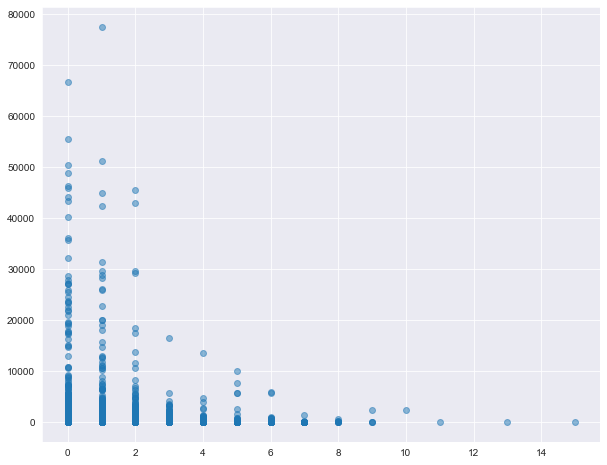

In [16]:


plt.figure(figsize=(10,8))

y = WSB_df["upvotes_tot"]
X = WSB_df["numbers"]
plt.scatter(X,y, alpha = 0.5)
plt.show()

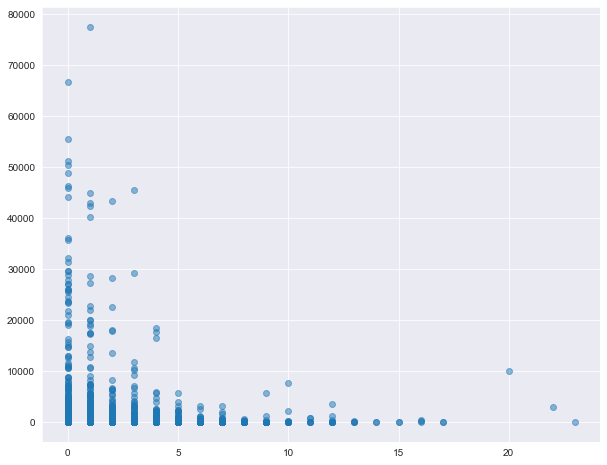

In [17]:


plt.figure(figsize=(10,8))

y = WSB_df["upvotes_tot"]
X = WSB_df["symbols"]
plt.scatter(X,y, alpha = 0.5)
plt.show()

I see negative relations.

## Popularity

In [45]:
WSB_df.loc[WSB_df.upvotes_tot >= 684, 'popularity'] = 1
WSB_df.loc[WSB_df.upvotes_tot < 684, 'popularity'] = 0

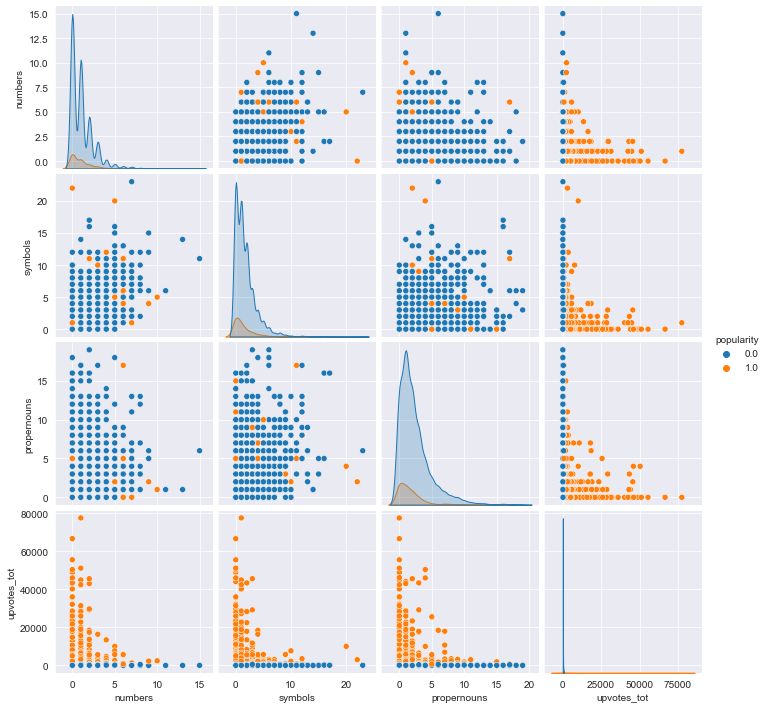

In [46]:
sns.pairplot(WSB_df, vars = ['numbers','symbols','propernouns', 'upvotes_tot'], hue = 'popularity')

## Keyword Extraction

In [20]:
import yake

In [21]:
kw_extractor = yake.KeywordExtractor()
keywordlist = []
for i in title.index:
    text = title[i]
    language = "en"
    max_ngram_size = 3
    deduplication_threshold = 0.9
    numOfKeywords = 20
    custom_kw_extractor = yake.KeywordExtractor(lan = language, n = max_ngram_size, dedupLim=deduplication_threshold,
                                                   top=numOfKeywords, features= None)
    
    keywords = custom_kw_extractor.extract_keywords(text)
    keywordlist.append(min(keywords,default="EMPTY")[0])

In [22]:
WSB_df['keyword'] = keywordlist

In [24]:
WSB_df['keyword'][3:144]

5                    COIN
6               WISHtards
7                   Spare
8                    good
9                  Caught
              ...        
175                  RKLB
176                Casual
177                   NOK
179    Acquisition halted
180                  COCO
Name: keyword, Length: 141, dtype: object